In [27]:
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter
import matplotlib as mpl
import re
import geopy.distance 
from sklearn.cluster import KMeans

mpl.rcParams['figure.dpi']= 400
sns.set_style("white")
plt.rc("font", size=12)
plt.rc("axes", titlesize=16, titleweight="bold") 

In [56]:
BASE_PATH = "../data"
RAW_DATA_PATH = f"{BASE_PATH}/raw"
TMP_PATH = f"{BASE_PATH}/tmp"
FILE_PATTERN = RAW_DATA_PATH + "/*/OD*"
STATION_PATTERN = RAW_DATA_PATH + "/*/Stations*"
START_STATION = 6184
END_STATION = 6015
START_DATE = "2014-04-15"
END_DATE = "2017-11-15"
THOUSANDS_SYMBOL = " (000s)"
USE_CACHE = True
NUM_CLUSTER = 12

In [80]:
def load_data(path_pattern: str, parse_dates=False) -> pd.DataFrame:
    filepath = [pd.read_csv(name, parse_dates=parse_dates) for name in glob.glob(path_pattern)]
    df = pd.concat(filepath)
    return df

def convert_thousands(x, pos):
    return '%1.0f' % (x * 1e-3)

def set_plotting_template(ax, title:str="", thousands:bool=True, as_date=None, xlabel:str=" ", ylabel:str=" "):
    sns.despine(left=True, right=True)
    if thousands:
        formatter = FuncFormatter(convert_thousands)
        ax.get_yaxis().set_major_formatter(formatter)
        ylabel += THOUSANDS_SYMBOL
        title += THOUSANDS_SYMBOL
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)    
    ax.grid(axis='y')
    ax.set_title(title, loc="left")
    
    if as_date: 
        date_formatter = DateFormatter(as_date)
        ax.xaxis.set_major_formatter(date_formatter)
    return ax

def plot_barchart(dataframe: pd.DataFrame, title=None, ylabel=None, xlabel=None, thousands=True):
    dataframe.columns = ["x", "y"]
    fig, ax = plt.subplots(figsize= (16, 4))
    ax = sns.barplot(x="x", y="y", data = dataframe, color="royalblue")
    ax = set_plotting_template(ax, title=title, ylabel=ylabel, xlabel=xlabel, thousands=thousands)

In [33]:
df = load_data(FILE_PATTERN, parse_dates=["start_date", "end_date"])
df = df.loc[
        (df.start_date >= START_DATE) &
        (df.end_date < END_DATE)
    ].reset_index(drop=True)


In [5]:
df.head()

,start_date,start_station_code,end_date,end_station_code,duration_sec,is_member
0,2014-08-01 00:00:00,6215,2014-08-01 00:11:00,6151,702,0
1,2014-08-01 00:00:00,6386,2014-08-01 00:03:00,6393,181,1
2,2014-08-01 00:00:00,6275,2014-08-01 00:08:00,6711,523,1
3,2014-08-01 00:00:00,6394,2014-08-01 00:02:00,6387,151,1
4,2014-08-01 00:01:00,6048,2014-08-01 00:17:00,6026,943,0


In [34]:
station = load_data(STATION_PATTERN)

In [7]:
station.head()

,code,name,latitude,longitude
0,6209,Milton / Clark,45.512520,-73.570620
1,6436,Côte St-Antoine / Clarke,45.486452,-73.595234
2,6214,Square St-Louis,45.517350,-73.569060
3,6248,St-Dominique / Rachel,45.518593,-73.581566
4,6164,Chambord / Laurier,45.532955,-73.584194


In [8]:
# make sure station codes are unique
station.drop_duplicates(inplace=True)
station.code.nunique()

546

Extract only the unique stations

In [9]:
investigate = station.groupby(["code"])[["latitude"]].count()
passed_stations = station.loc[station.code.isin(investigate.loc[investigate.latitude == 1].index.tolist())]
assert len(passed_stations) == passed_stations.code.nunique()
passed_stations.shape

(317, 4)

There are station codes associted with multiple records, 3 things that might happen: <br/>
- 1. same station name, different lat long measurments over the year
- 2. different station name, but station didn't physically moved or didn't move far.
- 3. station moved far, or they use an old code for a new station

The first two are fine, but the last one might be problematic, need to investigate, we will ignore it in the pipeline

In [10]:
problematic_stations = station.loc[station.code.isin(investigate.loc[investigate.latitude > 1].index.tolist())]

In [11]:
problematic_stations.code.nunique()

229

For the first case, same station name, takes averages on lat long. and add them to passed_stations df.

In [12]:
noisy_measurements = problematic_stations.groupby(["code", "name"])[["latitude"]].count().reset_index()
noisy_measurements = problematic_stations.loc[problematic_stations.code.isin(noisy_measurements.loc[noisy_measurements.latitude > 1, "code"])]

fixed_noisy_measurement = noisy_measurements.groupby(["code", "name"]).mean().reset_index()
problematic_stations = problematic_stations.loc[~problematic_stations.code.isin(
    noisy_measurements.loc[noisy_measurements.latitude > 1, "code"])]
passed_stations = pd.concat([passed_stations, fixed_noisy_measurement])
assert len(passed_stations) == passed_stations.code.nunique()
problematic_stations.code.nunique()

103

In [13]:
pairewise_distances = problematic_stations.groupby("code").apply(
    lambda grp: geopy.distance.distance(
    (grp.iloc[0]["latitude"], grp.iloc[0]["longitude"]),
    (grp.iloc[1]["latitude"], grp.iloc[1]["longitude"])
).km * 1_000)

For simplicity, I will assume two different stations sharing the same code with distance less than 100m are similar, and consider them the same station and take average of their measurements. For stations with distance more than 100m, I will ignore them for now. luckily we only have 21 of those station.

In [14]:
sum(pairewise_distances > 100)

21

In [15]:
ignored_stations = pairewise_distances[pairewise_distances > 100].index.tolist()

In [16]:
problematic_stations = problematic_stations.loc[~problematic_stations.code.isin(ignored_stations)].groupby("code").agg(
{
    "name": max, 
    "latitude": "mean", 
    "longitude": "mean"
}
).reset_index()

In [17]:
passed_stations = pd.concat([passed_stations, problematic_stations])

In [18]:
passed_stations.shape

(525, 4)

we will put our focus on the 525 stations

In [20]:
print(passed_stations[["latitude", "longitude"]].max())
print(passed_stations[["latitude", "longitude"]].min())

latitude     45.582757
longitude   -73.495067
dtype: float64
latitude     45.430740
longitude   -73.670374
dtype: float64


**Visualize the bike station network**

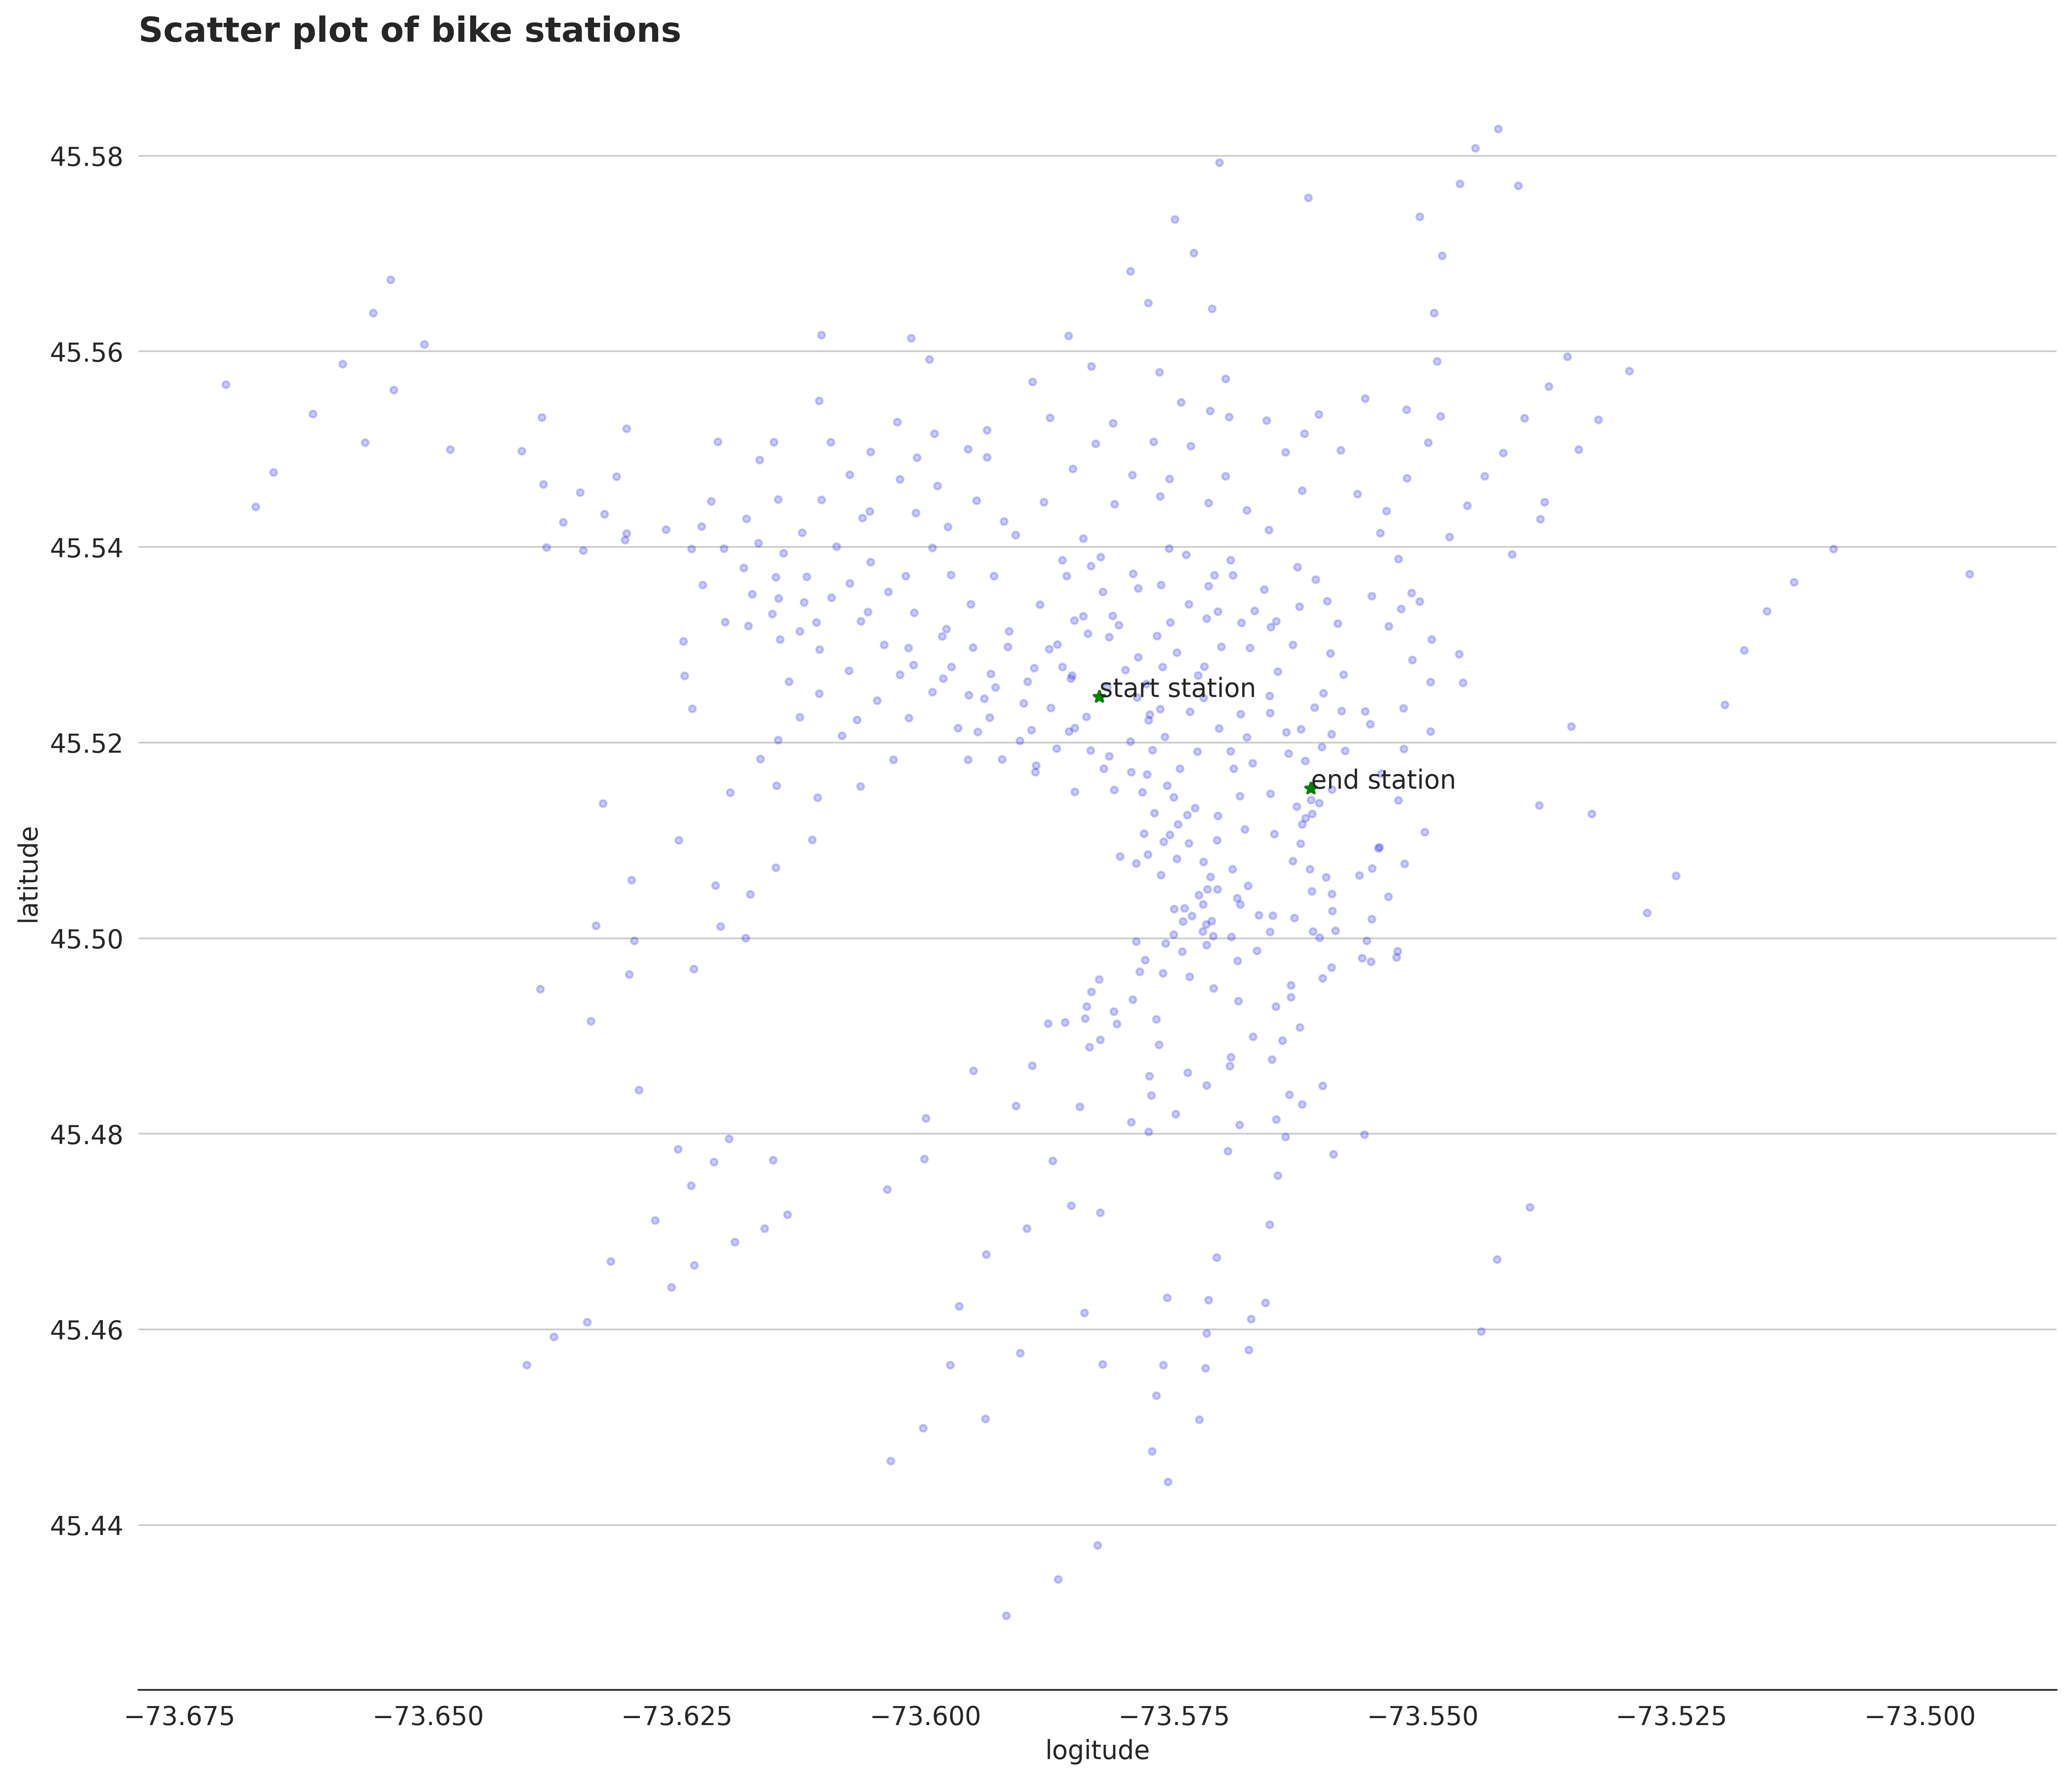

In [26]:
start_latitude = passed_stations.loc[passed_stations.code == START_STATION, "latitude"].values[0]
start_longitude = passed_stations.loc[passed_stations.code == START_STATION, "longitude"].values[0]
end_latitude = passed_stations.loc[passed_stations.code == END_STATION, "latitude"].values[0]
end_longitude = passed_stations.loc[passed_stations.code == END_STATION, "longitude"].values[0]

fig, ax = plt.subplots(figsize = (16,14))

ax.scatter(passed_stations.longitude, passed_stations.latitude, zorder=1, alpha= 0.2, c='b', s=10)
ax = set_plotting_template(ax, xlabel="logitude", ylabel="latitude", title="Scatter plot of bike stations", thousands=False)
ax.text(start_longitude, start_latitude,"start station")
ax.text(end_longitude, end_latitude, "end station")
plt.plot(start_longitude, start_latitude, 'g*')
plt.plot(end_longitude, end_latitude, 'g*')

In [38]:
df_clearn = df.loc[~df.start_station_code.isin(ignored_stations)].copy()

In [39]:
df_clearn.head()

,start_date,start_station_code,end_date,end_station_code,duration_sec,is_member
0,2014-08-01 00:00:00,6215,2014-08-01 00:11:00,6151,702,0
1,2014-08-01 00:00:00,6386,2014-08-01 00:03:00,6393,181,1
2,2014-08-01 00:00:00,6275,2014-08-01 00:08:00,6711,523,1
3,2014-08-01 00:00:00,6394,2014-08-01 00:02:00,6387,151,1
4,2014-08-01 00:01:00,6048,2014-08-01 00:17:00,6026,943,0


In [40]:
df_clearn.drop(["end_date", "end_station_code", "duration_sec", "is_member"], axis=1, inplace=True)

In [41]:
clus = df_clearn.merge(passed_stations, left_on="start_station_code", right_on="code")
clus = clus[["code", "latitude", "longitude"]]

In general, some city areas are busier than the others, ie. business district, school district etc and since the station are in close proximaty to each others, It maybe good to analyse them in clusters and use clustered areas as features for training. <br>
One method would be be to bucketize lat, long then do a feature cross between lat long, resulting in n X n grids. which I will exame further in the feature engineering session<br><br>
In the following, I would like to utilise Kmean clustering to see whether it can yield meaningful cluster.<br>
Try to find good clusters using elbow method

In [90]:
def build_elbow_curve(data, max_cluster):
    sum_of_squared_distances = []
    K = range(1, max_cluster)
    for k in K:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        sum_of_squared_distances.append(kmeans.inertia_)
    cluster = pd.DataFrame({"k": K, "ssd": sum_of_squared_distances})
    return cluster


try:
    cluster = pd.read_csv(f"{TMP_PATH}/kmean_clusters.csv")
    cluster_found = True
except FileNotFoundError: 
    cluster_found = False

if not (USE_CACHE and cluster_found):
    cluster = build_elbow_curve(clus[["latitude", "longitude"]], NUM_CLUSTER)
    cluster.to_csv(f"{TMP_PATH}/kmean_clusters.csv", index=False)

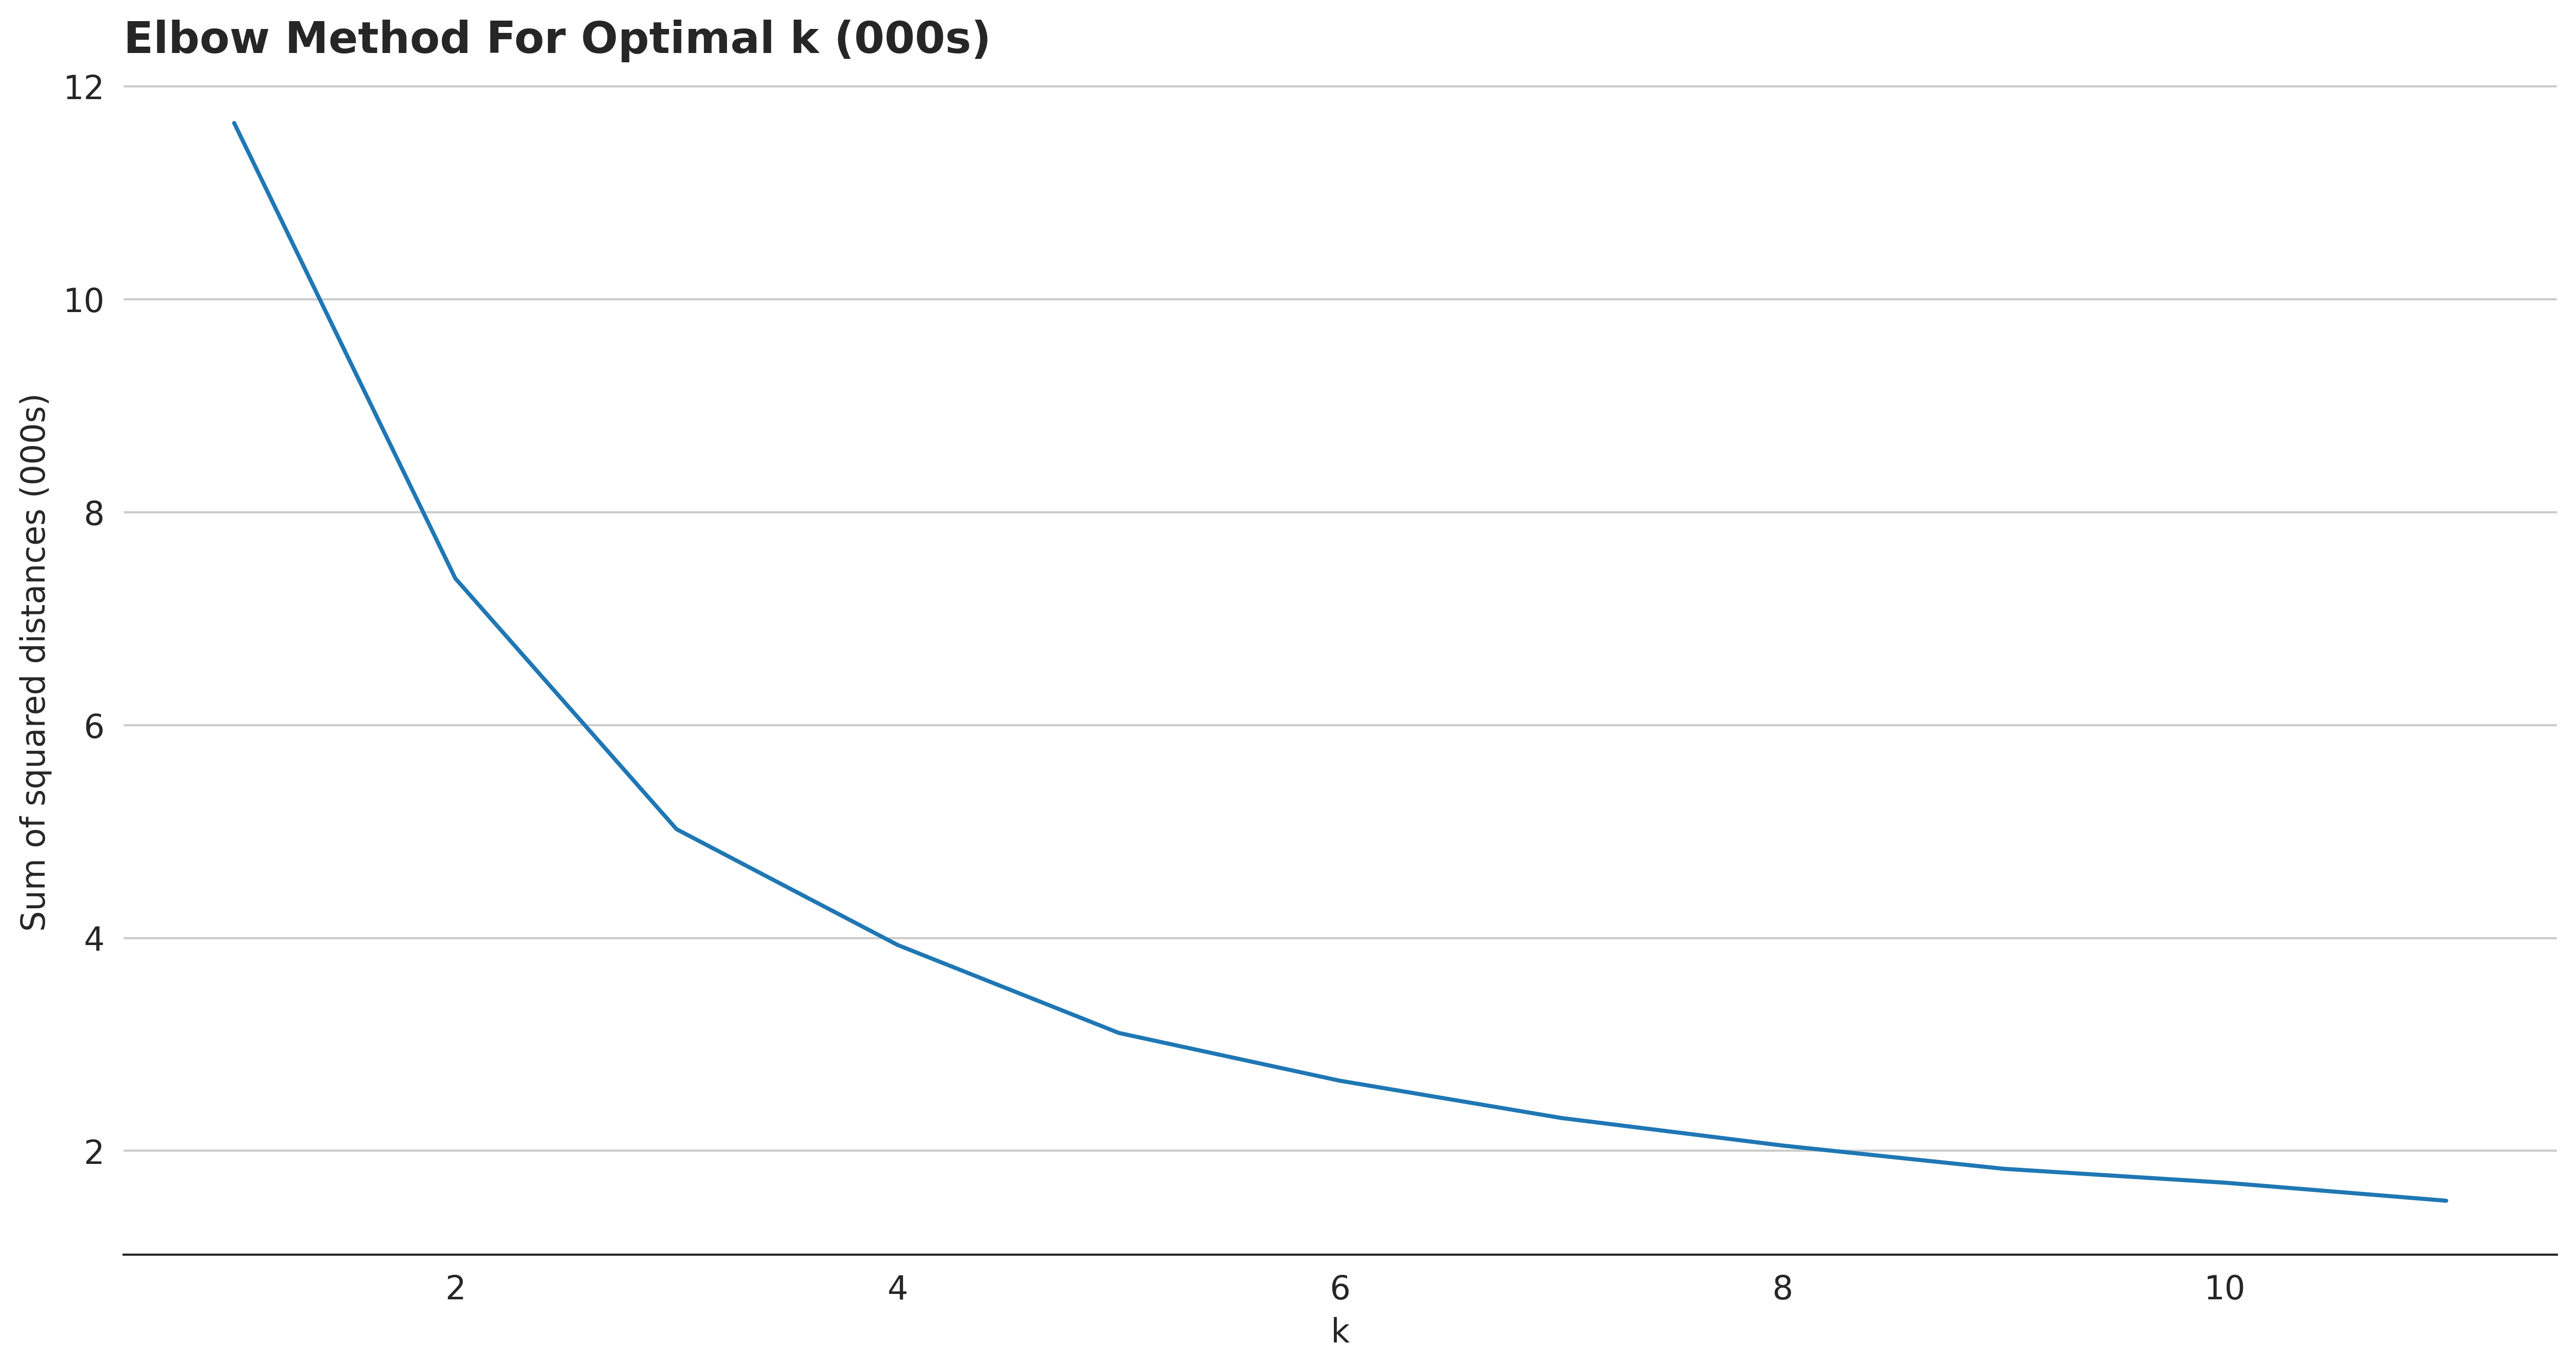

In [91]:
fig, ax = plt.subplots(figsize = (16,8))
sns.lineplot(x="k", y="ssd", data=cluster)
ax = set_plotting_template(ax, xlabel="k", ylabel="Sum of squared distances", title="Elbow Method For Optimal k")

In [81]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(clus[["latitude", "longitude"]])
clus["cluster"] = kmeans.predict(clus[["latitude", "longitude"]])

In [82]:
traffic_by_cluster = clus.groupby("cluster")["latitude"].count().reset_index()
traffic_by_cluster.columns = ["cluster", "total_traffic"]
traffic_by_cluster

,cluster,total_traffic
0,0,2654442
1,1,2892377
2,2,1046418
3,3,1372387
4,4,507148
5,5,1696559
6,6,1882635
7,7,566442
8,8,699364
9,9,1488981


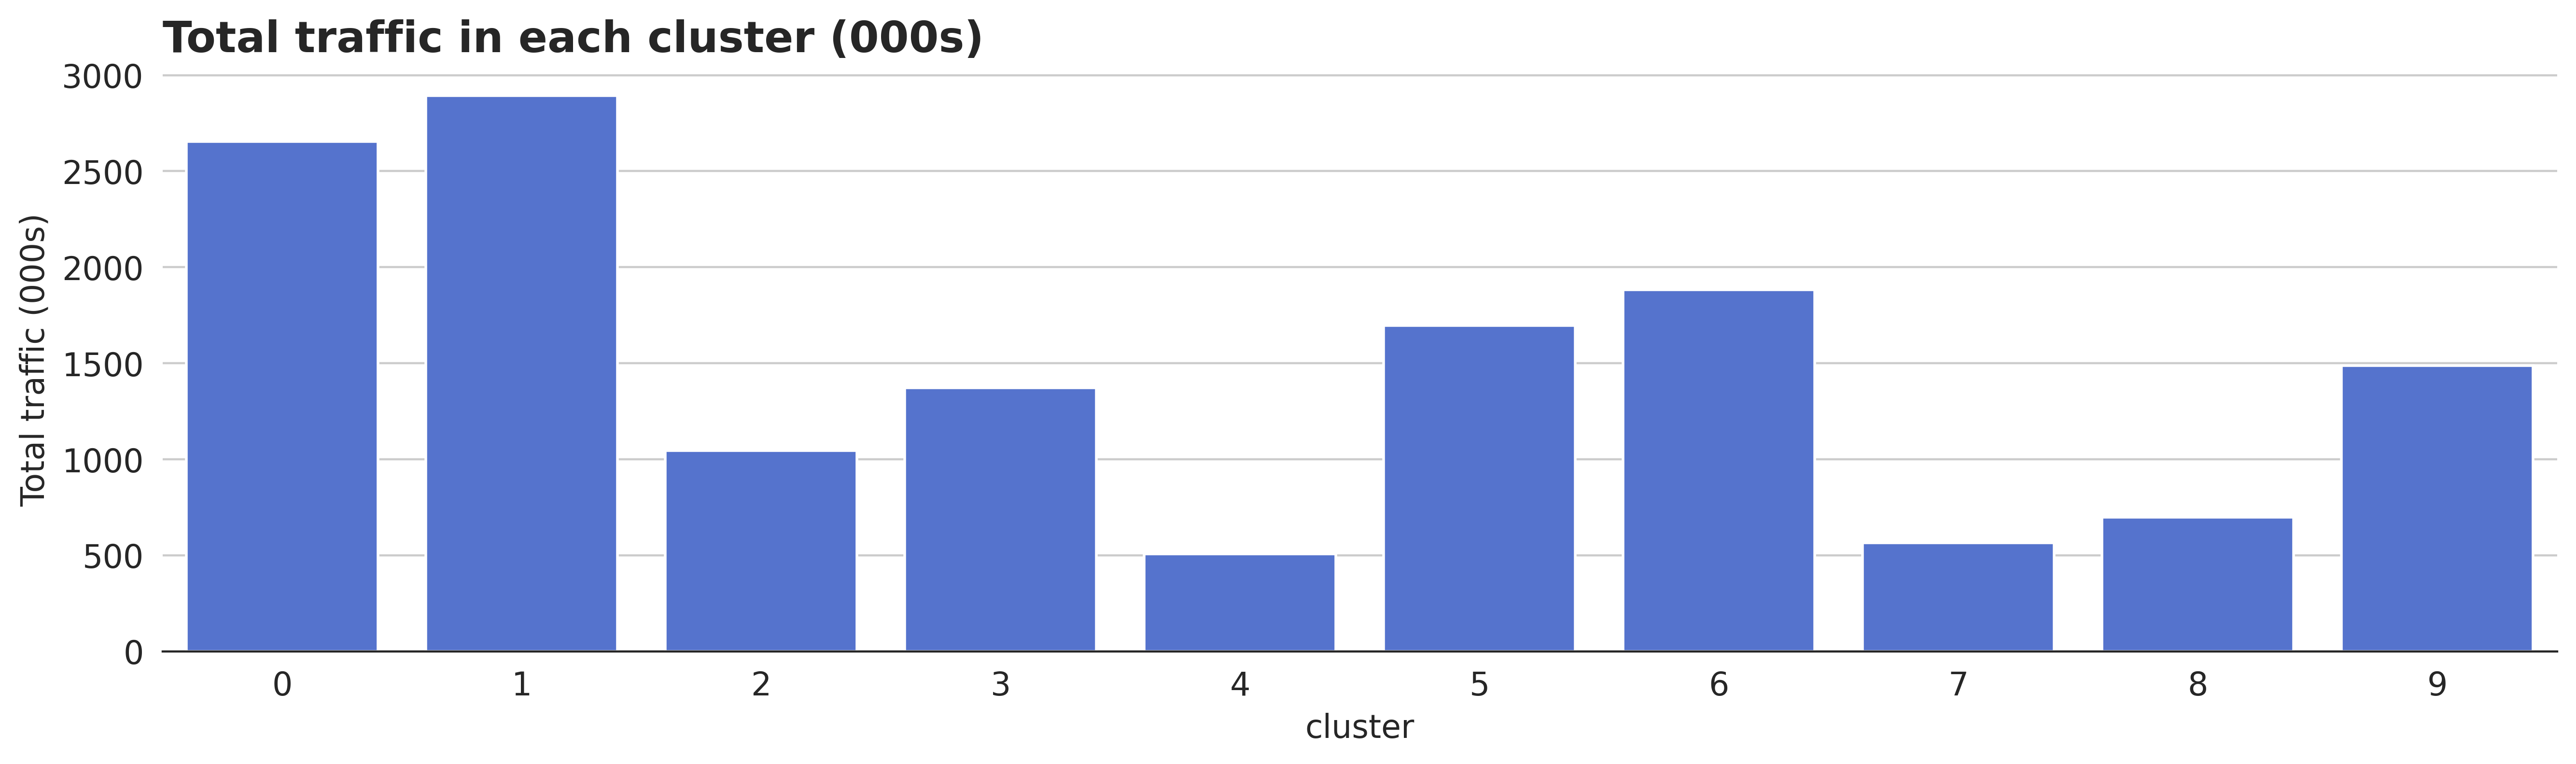

In [83]:
plot_barchart(traffic_by_cluster, title="Total traffic in each cluster", xlabel="cluster", ylabel="Total traffic")

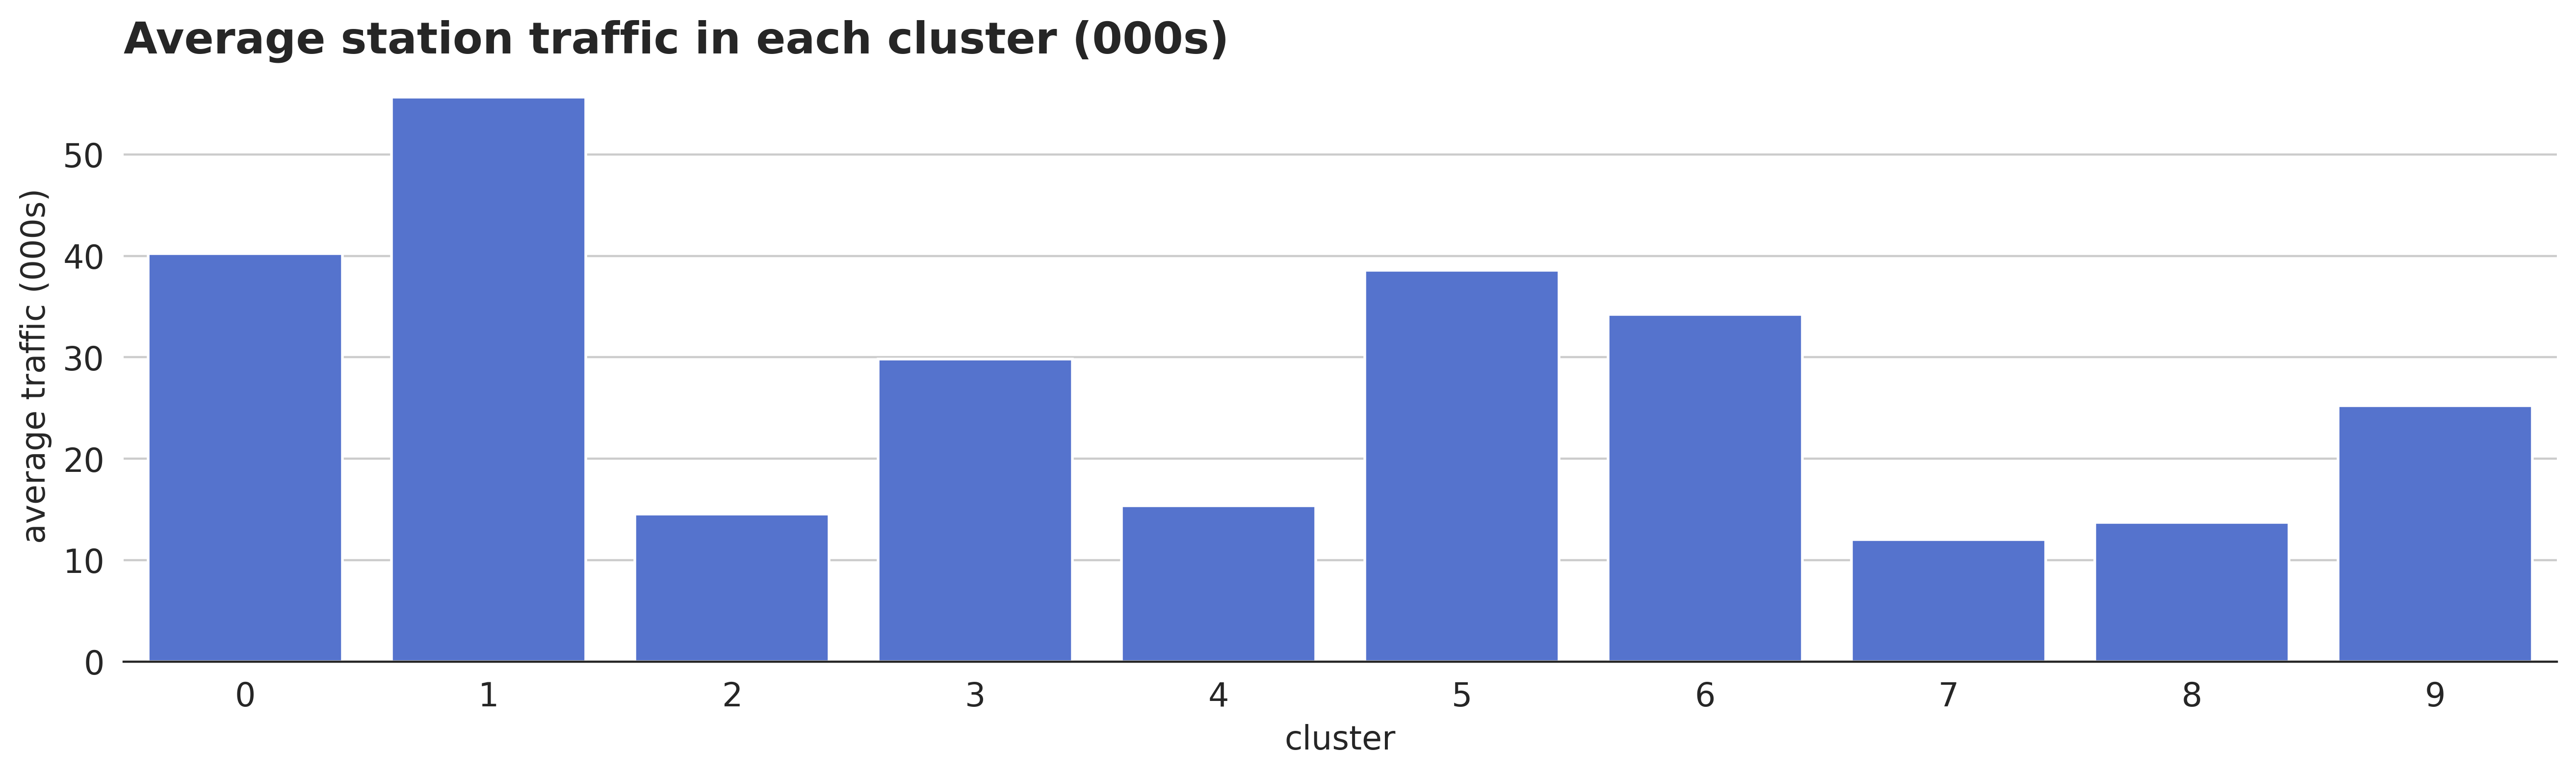

In [85]:
station_traffic = clus.groupby(["cluster", "code"])[["latitude"]].count()
average_station_traffic = station_traffic.groupby(station_traffic.index.get_level_values(0)).mean().astype(int).reset_index()
average_station_traffic.columns = ["cluster", "total_traffic"]
plot_barchart(average_station_traffic, title="Average station traffic in each cluster", xlabel="cluster", ylabel="average traffic")

Both total traffic in cluster and average station traffic in cluster show there are some meaningful differentiation in each cluster. we will consider utilising these info for our model

Next we will have a look at the cluster centers in the station network

In [86]:
kmeans.cluster_centers_

array([[ 45.49978557, -73.57404256],
       [ 45.51975278, -73.57819682],
       [ 45.54060875, -73.61799828],
       [ 45.52634078, -73.56112541],
       [ 45.48616652, -73.61755724],
       [ 45.50751813, -73.55674156],
       [ 45.52678358, -73.5985651 ],
       [ 45.55081735, -73.54972567],
       [ 45.47231366, -73.57412368],
       [ 45.53887028, -73.57970614]])

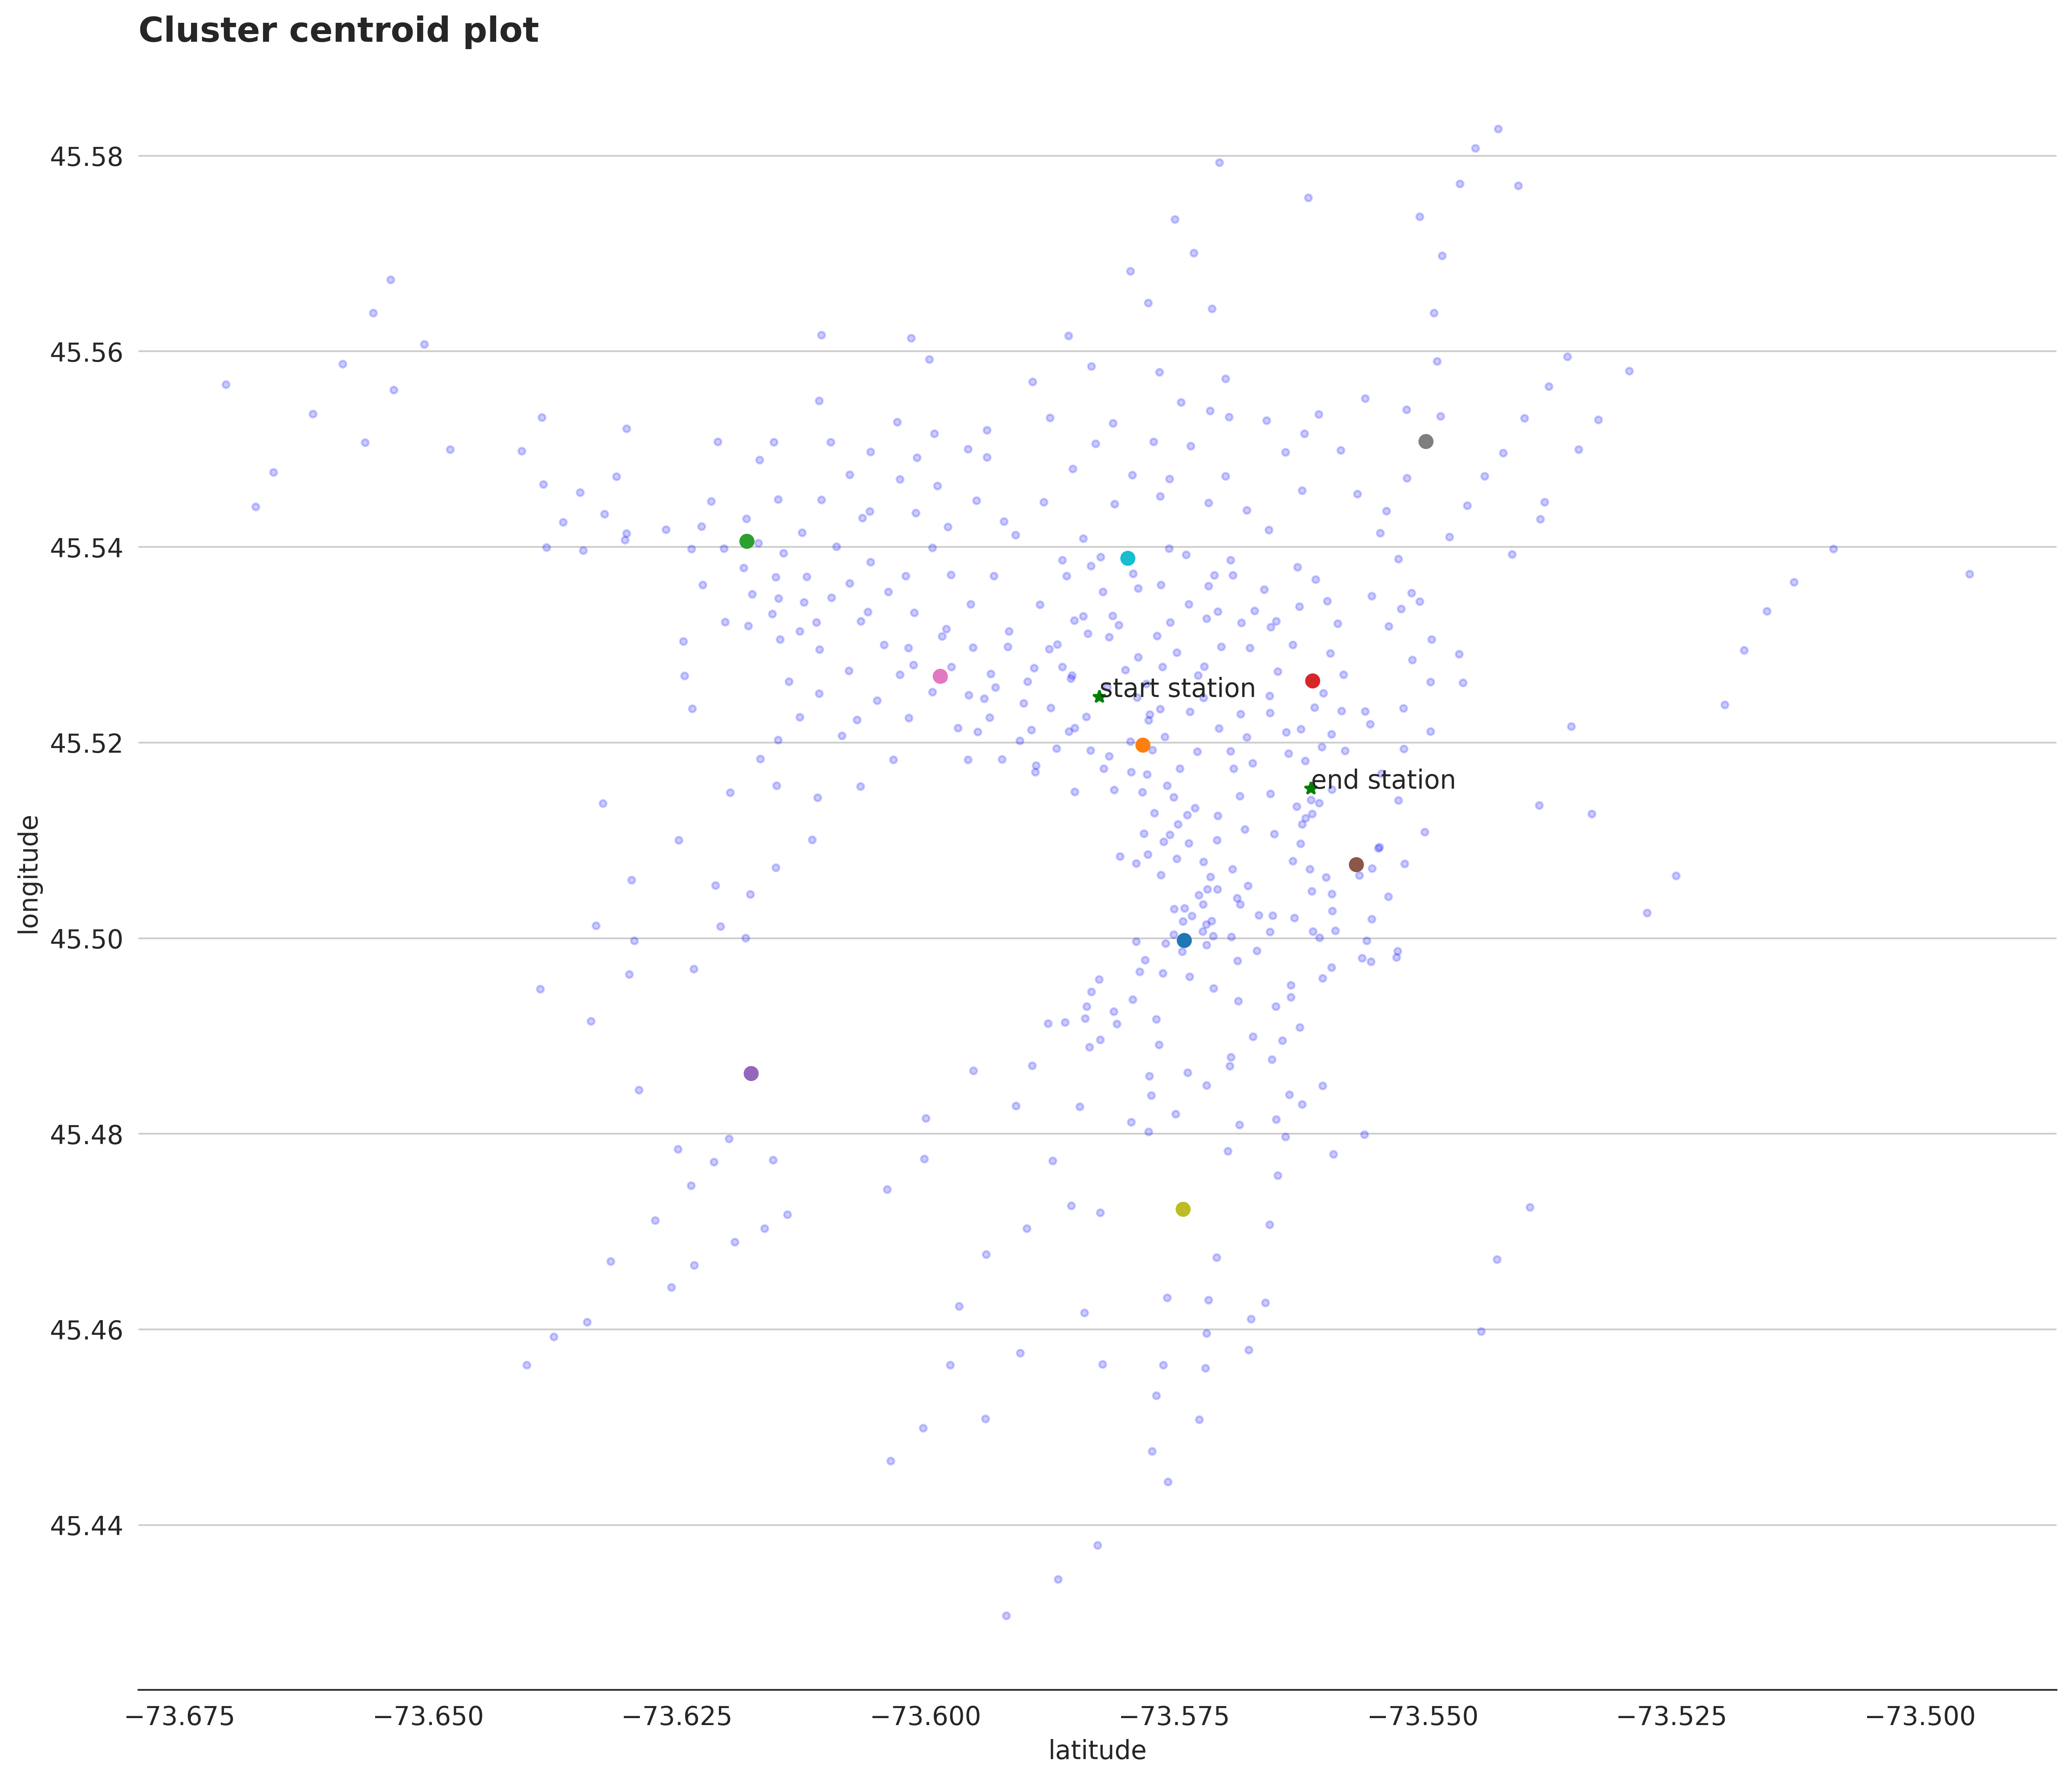

In [89]:
fig, ax = plt.subplots(figsize = (16,14))

ax.scatter(passed_stations.longitude, passed_stations.latitude, zorder=1, alpha= 0.2, c='b', s=10)
ax = set_plotting_template(ax, xlabel="latitude", ylabel="longitude", title="Cluster centroid plot", thousands=False)
ax.text(start_longitude, start_latitude,"start station")
ax.text(end_longitude, end_latitude, "end station")
plt.plot(start_longitude, start_latitude, 'g*')
plt.plot(end_longitude, end_latitude, 'g*')
for centre in kmeans.cluster_centers_:
    plt.plot(centre[1], centre[0], "o")